# Deep neural network model on synthesized time series

* Use linear regression and deep neural network to forecast a synthesized time siries
* Windowed time siries for training.
* Dynamic tuning of learning rate with callbacks.

## Create time series with trend + seasonality + noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.sin(season_time * 10 * np.pi),
                    1 / np.exp(10 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

* Synthesized time sires with trend, seasonality, and noise

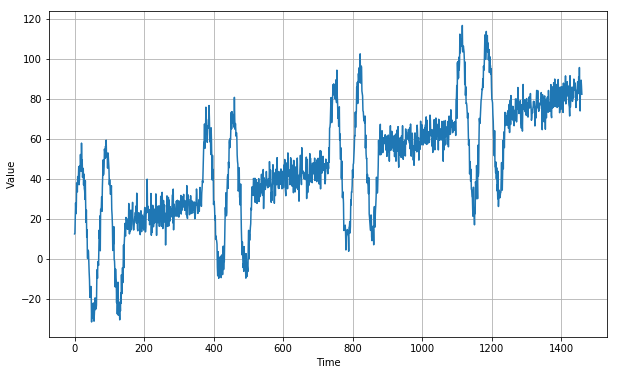

In [2]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series with trend and seasonality
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

* Split data to train and validation sets

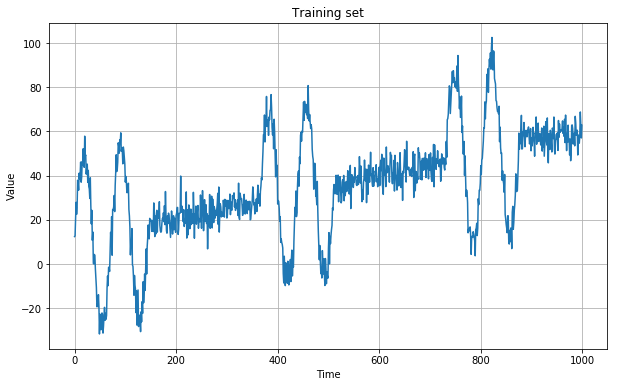

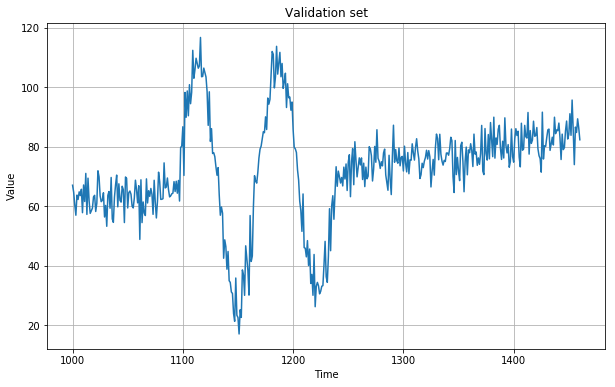

In [3]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.title("Training set")
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.title("Validation set")
plt.show()

## Windowed time series

* Time windows generator (with tf.data.Dataset) for creating input datasets for training neural network.

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Create tensorflow dataset from time serie array
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Create windowed (nested) dataset
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # Flattening out the windowed dataset with a given window size
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # Shuffling the dataset & separating dataset into inputs and labels
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    # Batch the input-label dataset with a given batch size
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Linear regression

* Here, we use linear regression with single-neuron single-layer neural network as a benchmark.
* The regression model is built with single-neuron single-layer neural network using keras.

In [5]:
# Create input dataset with training dataset
window_size = 20
batch_size = 30
shuffle_buffer_size = 1000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [6]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model1 = tf.keras.models.Sequential([l0])
# Use stochastic gradient method for optimizer
model1.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Training
history1 = model1.fit(dataset,epochs=200,verbose=0)
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 2.8342759e-02],
       [ 3.8905427e-02],
       [ 5.0931584e-02],
       [ 1.1882402e-03],
       [-1.7282719e-04],
       [-3.1855900e-02],
       [-9.7373396e-02],
       [-7.6834098e-02],
       [-8.0540039e-02],
       [-9.3553914e-03],
       [-3.2872748e-02],
       [ 2.0161573e-02],
       [-8.2754955e-02],
       [ 4.3310095e-02],
       [ 5.4594573e-02],
       [ 1.3409416e-01],
       [ 1.0725786e-01],
       [ 2.6999134e-01],
       [ 2.8623676e-01],
       [ 3.8917905e-01]], dtype=float32), array([0.0649704], dtype=float32)]


* Plotting the training history

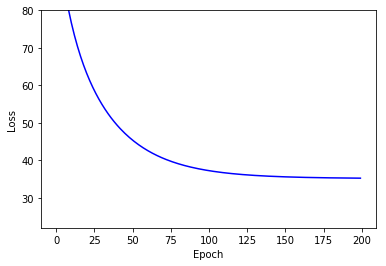

In [34]:
loss1 = history1.history['loss']
epochs1 = range(len(loss1))
plt.plot(epochs1, loss1, 'b', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([22,80])
plt.show()

* Plotting the prediction

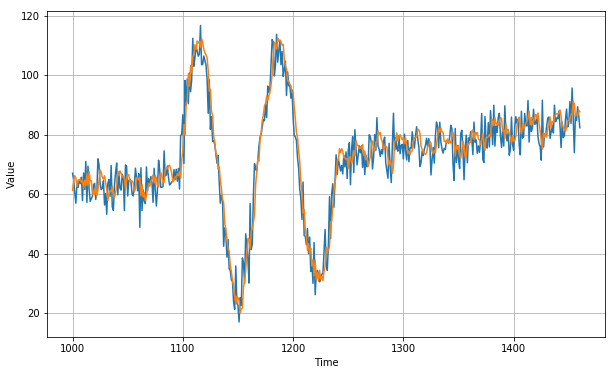

In [9]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model1.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
#print(np.array(forecast).shape)
results1 = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results1)
plt.show()

* Mean squre error and mean absolute error of the linear regression model

In [10]:
print("Linear regrassion MSE = ", keras.metrics.mean_squared_error(x_valid, results1).numpy())
print("Linear regrassion MAE = ", keras.metrics.mean_absolute_error(x_valid, results1).numpy())

Linear regrassion MSE =  37.493755
Linear regrassion MAE =  4.9310102


## Deep Neural Network

* Here we try to train a DNN model.
* First, dynamic tuning of learning rate with callbacks is used to choose an appropriate learning rate for training DNN.

In [13]:
# Two layer DNN
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Optimizer with initial learning rate
optimizer1 = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model2.compile(loss="mse", optimizer=optimizer1)

In [14]:
# Construct learning rate scheduler based on the number of epoch
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Training with callbacks
history2 = model2.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

* Plot the loss as a function of learning rate (lr is a function of the number of epoch)
* As it can be seen, the loss increases rapidly as the learning rate becomees too large. Learning rate < $10^{-5}$ should be used

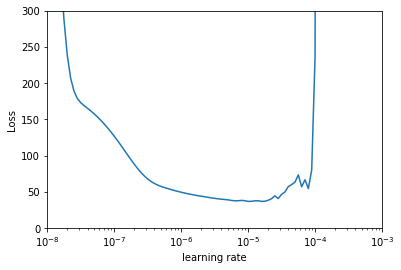

In [15]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history2.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])
plt.xlabel("learning rate")
plt.ylabel("Loss")
plt.show()

* Traing the model with appropriate learning rage.

In [22]:
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(100, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

# Learning rate
optimizer2 = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model3.compile(loss="mse", optimizer=optimizer2)
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               2100      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 3,121
Trainable params: 3,121
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Training
history3 = model3.fit(dataset, epochs=400, verbose=0)

* Plotting the training history
* As it can be seen, with appropriate learning rate, DNN can converge much faster than simple linear regression model, even if DNN has much more fitting parameters (3121 vs 21).

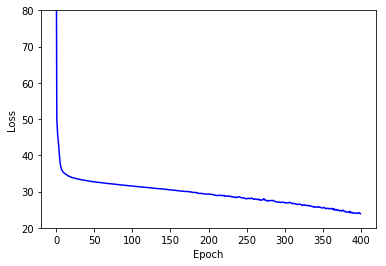

In [35]:
loss1 = history3.history['loss']
epochs1 = range(len(loss1))
plt.plot(epochs1, loss1, 'b', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([20,80])
plt.show()

* Prediction with DNN on validation set

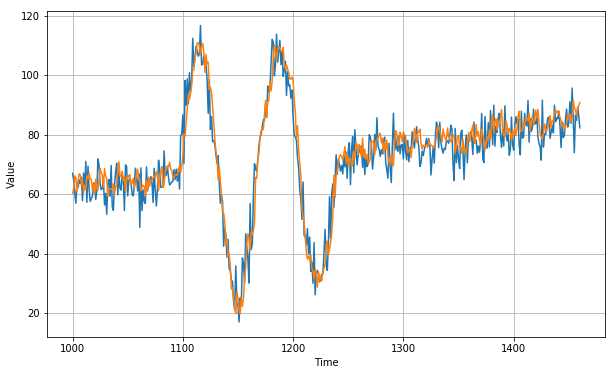

In [36]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model3.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results2 = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results2)
plt.show()

* Training of DNN is faster than linear regression model, and the loss on training data set decrease to a lower value than linear regression.
* However, the MSE and MAE of DNN is higher than that of linear regression model, indicating the overfitting during the training, and early stopping should be used.
* It also implies that complex model is not necessarily better than simple models.

In [38]:
print("MSE = ", keras.metrics.mean_squared_error(x_valid, results2).numpy())
print("MAE = ", keras.metrics.mean_absolute_error(x_valid, results2).numpy())

MSE =  40.423
MAE =  5.06034
